### Visualizing incoming tweets using Spark streaming

Loading essential libraries:

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

Creating Spark Context and Streaming context:

In [ ]:
sc = SparkContext()
ssc = StreamingContext(sc, 10)

Creating an input stream from the port and processing tweets into tags and counts:

In [ ]:
socket_stream = ssc.socketTextStream("ec2-X-X-X-X.compute-X.amazonaws.com", 5555) # use your AWS EC2 Machine ID here

lines = socket_stream.window( 20 )      # using a 20 second window to collect tweets

# Creating structure to collect tweet 
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields)

# Splitting and storing in proper format
( lines.flatMap( lambda text: text.split( " " ) ).filter( lambda word: word.lower().startswith("#") ).map( lambda word: ( word.lower(), 1 ) ).reduceByKey( lambda a, b: a + b ).map( lambda rec: Tweet( rec[0], rec[1] ) ).foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ).limit(10).registerTempTable("tweets") ) )

# Creating sql context
sqlContext = SQLContext(sc)

Checking if spark context has been created properly before computing:

In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
ssc.start()          # Start the computation

Plotting the input stream of words as a bar graph displaying hashtag counts within a certain timeframe:

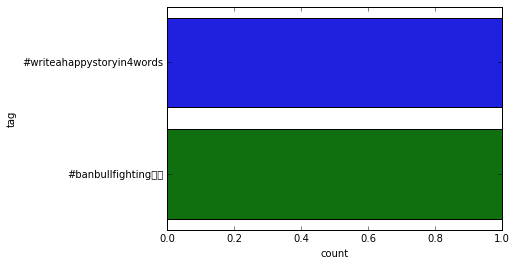

In [7]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import time
from IPython import display

sn.palplot(sn.color_palette("Paired"))

count = 0
while count < 10:
  time.sleep( 20 )
  top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
  top_10_df = top_10_tweets.toPandas()
  display.clear_output(wait=True)
  #plt.figure( figsize = ( 10, 8 ) )
  sn.barplot( x="count", y="tag", data=top_10_df)
  plt.show()
  count = count + 1
    

In [ ]:
ssc.stop()     # Stop the computation

Once the computation is stopped, stop running the file creating the input stream:

In [ ]:
!pkill -f 'python TweetRead.py'